# Curved arch
#### April 2020, Amir Hossein Namadchi
This is an OpenSeesPy simulation of one of the numerical examples in [A robust composite time integration scheme for snap-through problems](https://link.springer.com/article/10.1007/s00466-015-1152-3) by *Yenny Chandra* et. al. It's a special problem involving dynamic snap-through with large deformations in elastic range. In their study, a new three sub-step composite time integration algorithm was presented to handle such problems. Here, I will use the Bathe scheme (`TRBDF2`) to perform transient analysis. 

![Curved Arch](imgs/CurvedArch.PNG)

In [1]:
import numpy as np
import openseespy.opensees as ops
import matplotlib.pyplot as plt

from time import process_time

Below, the base units are defined as python variables:

In [2]:
# Units
mm = 1.0   # milimeters
N = 1.0    # Newtons
sec = 1.0  # Seconds

### Model Defintion

In [3]:
# Node Coordinates Matrix (size : nn x 3)
node_coords = np.array([[-152.4, 0], [-137.337, 2.91714],
                        [-122.218, 5.53039], [-107.049, 7.8387],
                        [-91.8371, 9.84114], [-76.5878, 11.5369],
                        [-61.3076, 12.9252], [-46.0024, 14.0057],
                        [-30.6787, 14.7777], [-15.3424, 15.2411],
                        [0, 15.3955], [15.3424, 15.2411], 
                        [30.6787, 14.7777], [46.0024, 14.0057],
                        [61.3076, 12.9252], [76.5878, 11.5369], 
                        [91.8371, 9.84114], [107.049, 7.8387], 
                        [122.218, 5.53039], [137.337, 2.91714],
                        [152.4, 0]], dtype = np.float64)*mm

# Element Connectivity Matrix (size: nel x 2)
connectivity = [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], 
                [6, 7], [7, 8], [8, 9], [9, 10], [10, 11],
                [11, 12], [12, 13], [13, 14], [14, 15], 
                [15, 16], [16, 17], [17, 18], [18, 19],
                [19, 20], [20, 21]]

# Get Number of total Nodes
nn = len(node_coords)
# Get Number of total Elements
nel = len(connectivity)

#Boundary Conditions (size: fixed_nodes x 4)
B_C = [[1,1,1,1],
       [nn,1,1,1]]


# Modulus of Elasticity
E = 206843*(N/mm**2)
# Mass Density
rho = (7.83e-9)*(N*(sec**2)/(mm**4))
# Cross-sectional area, 2nd Moment of Inertia
A, I_1 = (12.7*0.6096*mm*mm,
          (1/12)*(12.7*(0.6096**3))*mm**4)



ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

# Adding nodes to the model object using list comprehensions
[ops.node(n+1,*node_coords[n]) for n in range(nn)];

# Applying BC
[ops.fix(B_C[n][0],*B_C[n][1:]) for n in range(len(B_C))];


#Set Transformation
ops.geomTransf('Corotational', 1)

# Adding Elements
[ops.element('elasticBeamColumn', e+1, *connectivity[e], A, E, I_1,1,
            '-mass',rho*A,'-cMass',1) for e in range(nel)];

# load function (Applied @ top node)
F = lambda t: (t if t<=8 else 8)*N

# Dynamic Analysis Parameters
dt = 0.0001
time = 15
time_domain = np.arange(0,time,dt)


# Loading Definition
ops.timeSeries('Path',1 , '-dt', dt,
               '-values', *np.vectorize(F)(time_domain),
               '-time', *time_domain)
ops.pattern('Plain', 1, 1)
ops.load(11, *[0.0, -1.0, 0.0])

# Analysis
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('ProfileSPD')
ops.test('NormUnbalance', 0.000001, 100)
ops.algorithm('Newton')
ops.integrator('TRBDF2')
ops.analysis('Transient')


# let's do this
time_lst =[]     # list to hold time stations for plotting
d_list = []      # list to hold vertical displacments of the top node

# start the timer
tic = process_time()

for i in range(len(time_domain)):
    ops.analyze(1, dt)
    time_lst.append(ops.getTime())
    d_list.append(ops.nodeDisp(11,2))

# stop the timer
toc = process_time()   

print('Time elapsed:',toc-tic, 'sec')

Time elapsed: 29.2345874 sec


### Visualization

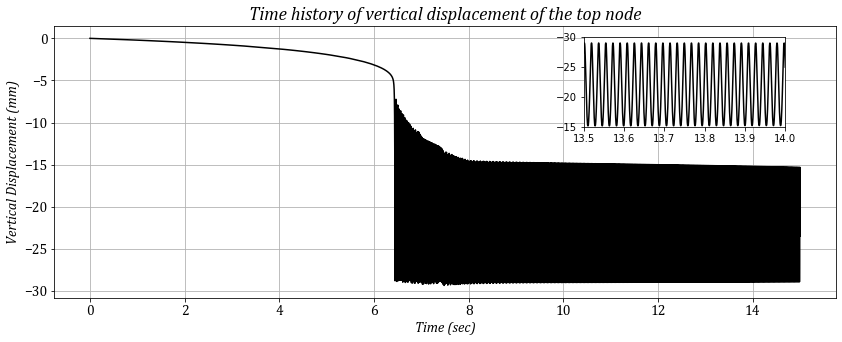

In [4]:
plt.figure(figsize=(14,5))
ax1 = plt.axes()  # standard axes
plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14)
plt.title('Time history of vertical displacement of the top node',
          {'fontname':'Cambria',
           'fontstyle':'italic','size':18});

ax2 = plt.axes([0.65, 0.60, 0.2, 0.25])


ax1.plot(time_lst, d_list,'k')
ax2.plot(time_lst, d_list,'k')
ax2.set_xlim(left=13.5, right=14)
ax2.set_ylim(bottom=-15, top=-30)

ax1.set_xlabel('Time (sec)', {'fontname':'Cambria',
                            'fontstyle':'italic','size':14})
ax1.set_ylabel('Vertical Displacement (mm)', {'fontname':'Cambria',
                                 'fontstyle':'italic','size':14});


### Closure
The figure deomnstrates a dynamic jump from the quasi static configuration. It then begins to oscillate around the remote equilibrium configuration. It is to be noted that conventional time integration algorithm like the *Newmark* method might not be able to present a stable and bounded solution like this. It is therefore necessary to employ an energy-conserving algorithms with proper numerical dissipation in order to tackle these kind of problems (like `TRBDF2` and `TRBDF3` in OpenSees).

### References
- <blockquote>Chandra, Y., Zhou, Y., Stanciulescu, I., Eason, T. and Spottswood, S., 2015. A robust composite time integration scheme for snap-through problems. Computational Mechanics, 55(5), pp.1041-1056.</blockquote>